In [353]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_friedman1
from sklearn.datasets import make_regression
import numpy as np

In [293]:
X_data1, y_data1 = make_friedman1(n_samples=6000, n_features=10, noise=100)
X_data2, y_data2 = make_regression(n_samples=6000, n_features=10, noise=500)
X_data = np.array(list(X_data1[1000:]) + list(X_data2[:-1000]))
y_data = np.array(list(y_data1[1000:]) + list(y_data2[:-1000]))
X_validation = np.array(list(X_data1[:1000]) + list(X_data2[-1000:]))
y_validation = np.array(list(y_data1[:1000]) + list(y_data2[-1000:]))

In [295]:
algo = LinearRegression().fit(X_data, y_data)

In [296]:
algo2 = DecisionTreeRegressor(max_depth=6).fit(X_data, np.abs(y_data - algo.predict(X_data)))

In [297]:
import matplotlib.pyplot as plt
%matplotlib inline

In [298]:
(np.sqrt(np.pi / 2) * np.mean(algo2.predict(X_data[:5000])))

122.23008343690745

In [299]:
(np.sqrt(np.pi / 2) * np.mean(algo2.predict(X_data[5000:])))

509.06649193808465

In [300]:
from sklearn.model_selection import KFold

In [380]:
def build_up_conformal_prediction(train_estimator, err_estimator, X, y, n_splits, passes=1):
    X_err, y_err = [], []
    for random_state in range(passes):
        print random_state
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        for train_indices, test_indices in kfold.split(X):
            X_train = X[train_indices, :]
            y_train = y[train_indices]
            X_test = X[test_indices, :]
            y_test = y[test_indices]

            algo = train_estimator.fit(X_train, y_train)
            pred = algo.predict(X_test)
            err = np.abs(y_test - pred)

            X_err.extend(X_test)
            y_err.extend(err)
        
    X_err = np.array(X_err)
    y_err = np.array(y_err)
    
    algo = err_estimator.fit(X_err, y_err)
    return algo
    

In [406]:
train_estimator = DecisionTreeRegressor(max_depth=8, random_state=42)

In [359]:
train_estimator = RandomForestRegressor(max_depth=10, n_estimators=20)

In [371]:
train_estimator = LinearRegression(fit_intercept=True)

In [354]:
train_estimator = KNeighborsRegressor(n_neighbors=4)

In [363]:
err_estimator = RandomForestRegressor(max_depth=10, n_estimators=20)

In [407]:
err_estimator = DecisionTreeRegressor(max_depth=8)

In [420]:
algo3 = build_up_conformal_prediction(
    train_estimator=train_estimator,
    err_estimator=err_estimator,
    X=X_data,
    y=y_data,
    n_splits=5,
    passes=10
)

0
1
2
3
4
5
6
7
8
9


In [421]:
(np.sqrt(np.pi / 2) * np.mean(algo3.predict(X_validation[:1000])))

102.85686519223945

In [422]:
(np.sqrt(np.pi / 2) * np.mean(algo3.predict(X_validation[1000:])))

560.69829728037189

In [423]:
sigmas = np.sqrt(np.pi / 2) * algo3.predict(X_validation)
preds = train_estimator.fit(X_data, y_data).predict(X_validation)
errors = y_validation - preds
np.mean(- 0.5 * np.log(sigmas_sqr * 2 * np.pi) - errors ** 2 / (sigmas_sqr * 2))

-6.9358819753954775

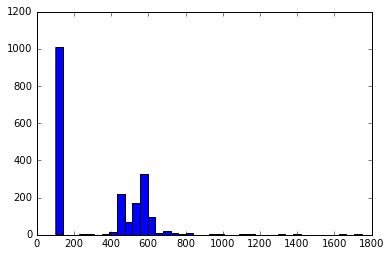

In [419]:
plt.hist(sigmas, bins=40)
plt.show()

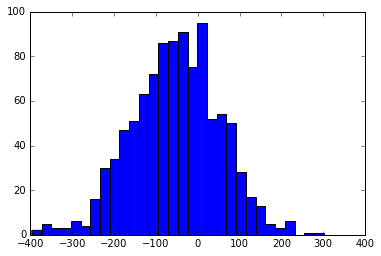

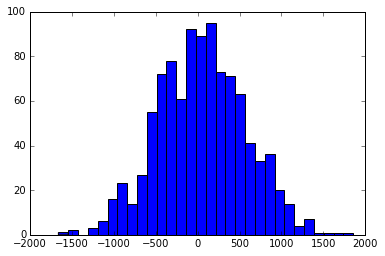

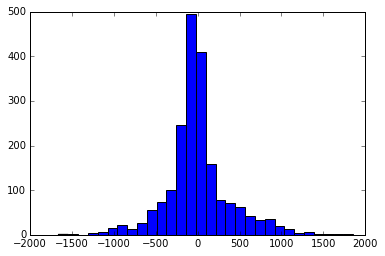

In [329]:
plt.hist(errors[:1000], bins=30)
plt.show()
plt.hist(errors[1000:], bins=30)
plt.show()
plt.hist(errors, bins=30)
plt.show()

In [330]:
np.sum(np.abs(errors) <= 1.96 * sigmas) * 1. / len(errors)

0.93049999999999999

In [331]:
sigmas_sqr = sigmas ** 2

In [369]:
np.mean(- 0.5 * np.log(sigmas_sqr * 2 * np.pi) - errors ** 2 / (sigmas_sqr * 2))

-6.9358819753954775

In [376]:
import libmxnet
import numpy as np
import subprocess
from sklearn.base import BaseEstimator
import os
import shutil
import time
from itertools import izip, imap
from sklearn.metrics import log_loss, mean_squared_error
from scipy.special import expit 

In [377]:
class SklearnMxnet(BaseEstimator):
    def __init__(
        self, iters_count=100, depth=None, 
        mxnet_mode='regressor', dicrete_levels=None,
        factors_fraction=None, f_taken_fraction=None,
        model_complexity=None, verbose=False
    ):
        assert(mxnet_mode in ['regressor', 'bin_classifier'])
        self.mxnet_mode = mxnet_mode
        self.iters_count = iters_count
        self.depth = depth
        self.dicrete_levels = dicrete_levels
        self.factors_fraction = factors_fraction
        self.f_taken_fraction = f_taken_fraction
        self.model_complexity = model_complexity
        self.verbose = verbose
    
    def fit(self, X, y):
        folder_name = '__tmp_mxnet_learn_{}'.format(time.time())
        os.makedirs(folder_name)
        
        with open(folder_name + '/train', 'w') as f:
            for i, (features, target) in enumerate(izip(X, y)):
                f.write('{query_id}\t{relevance}\t{label}\t{weight}\t{features}\n'.format(
                    query_id = 0,
                    relevance = target,
                    weight = 1,
                    label = i,
                    features = '\t'.join(imap(str, features)),
                ))
                
        cmd = ['matrixnet']
        cmd.extend(['-f', folder_name + '/train'])
        cmd.extend(['-o', folder_name + '/matrixnet'])

        if self.mxnet_mode == 'bin_classifier':
            cmd.extend(['-c', '--c-fast'])
            
        if self.dicrete_levels is not None:
            cmd.extend(['-x', str(self.dicrete_levels)])
            
        if self.factors_fraction is not None:
            cmd.extend(['-Z', str(self.factors_fraction)])
            
        if self.f_taken_fraction is not None:
            cmd.extend(['-S', str(self.f_taken_fraction)])
            
        if self.model_complexity is not None:
            cmd.extend(['-g', str(self.model_complexity)])
        
        if self.iters_count is not None:
            cmd.extend(['-i', str(self.iters_count)])
        
        if self.depth is not None:
            cmd.extend(['-n', str(self.depth)])
        
        process = subprocess.Popen(cmd, stdout=subprocess.PIPE)
        resp = process.communicate()[0]

        if self.verbose:
            print resp
        
        self.mxnet_ = libmxnet.TMXNetInfo(folder_name + '/matrixnet.info')
        
        shutil.rmtree(folder_name)
        return self
        
        
    def predict(self, X):
        try:
            getattr(self, "mxnet_")
        except AttributeError:
            raise RuntimeError("You must train mxnet before predicting data")
        prediction = np.array(self.mxnet_.Calculate([list(x) for x in X]))
        if self.mxnet_mode == 'bin_classifier':
            prediction = (expit(prediction) > 0.5).astype(int)
        return prediction
    
    def predict_proba(self, X):
        try:
            getattr(self, "mxnet_")
        except AttributeError:
            raise RuntimeError("You must train mxnet before predicting data")
        prediction = np.array(self.mxnet_.Calculate([list(x) for x in X]))
        if self.mxnet_mode == 'bin_classifier':
            prediction = expit(prediction)
        return prediction
    
    def get_params(self, deep=True):
        return {
            'mxnet_mode': self.mxnet_mode,
            'iters_count': self.iters_count,
            'depth': self.depth,
            'dicrete_levels': self.dicrete_levels,
            'factors_fraction': self.factors_fraction,
            'f_taken_fraction': self.f_taken_fraction,
            'model_complexity': self.model_complexity,
            'verbose': self.verbose
        }
    
    def set_params(self, **params):
        self.mxnet_mode = params.get('mxnet_mode', self.mxnet_mode)
        self.iters_count = params.get('iters_count', self.iters_count)
        self.depth = params.get('depth', self.depth)
        self.dicrete_levels = params.get('dicrete_levels', self.dicrete_levels)
        self.factors_fraction = params.get('factors_fraction', self.factors_fraction)
        self.f_taken_fraction = params.get('f_taken_fraction', self.f_taken_fraction)
        self.model_complexity = params.get('model_complexity', self.model_complexity)
        
        self.verbose = params.get('verbose', self.verbose)
        
        return self
    
    def score(self, X, y):
        y_pred = self.predict_proba(X)
        if self.mxnet_mode == 'bin_classifier':
            return log_loss(y, y_pred)
        if self.mxnet_mode == 'regressor':
            return - mean_squared_error(y, y_pred)

In [397]:
algo3 = build_up_conformal_prediction(
    train_estimator=SklearnMxnet(iters_count=200),
    err_estimator=SklearnMxnet(iters_count=200),
    X=X_data,
    y=y_data,
    n_splits=5,
    passes=10
)

0
1
2
3
4
5
6
7
8
9


In [398]:
sigmas = np.sqrt(np.pi / 2) * algo3.predict(X_validation)
preds = SklearnMxnet(iters_count=200).fit(X_data, y_data).predict(X_validation)
errors = y_validation - preds
np.mean(- 0.5 * np.log(sigmas_sqr * 2 * np.pi) - errors ** 2 / (sigmas_sqr * 2))

-6.891223224340373

In [399]:
(np.sqrt(np.pi / 2) * np.mean(algo3.predict(X_validation[:1000])))

109.68226327421861

In [400]:
(np.sqrt(np.pi / 2) * np.mean(algo3.predict(X_validation[-1000:])))

490.71180172324847

In [401]:
np.sum(np.abs(errors) <= 1.96 * sigmas) * 1. / len(errors)

0.94699999999999995

In [402]:
np.sum(np.abs(errors) <= 3 * sigmas) * 1. / len(errors)

0.99450000000000005

In [403]:
np.sum(np.abs(errors) <= 1. * sigmas) * 1. / len(errors)

0.68149999999999999

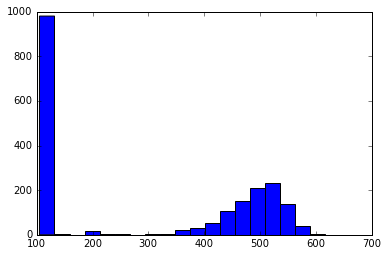

In [405]:
plt.hist(sigmas, bins=20)
plt.show()

In [525]:
X_data = []
y_data = []
for i in xrange(100):
    for j in xrange(100):
        a = i * 1. / 100
        b = j * 1. / 100
        val = (a * (1 - a) + a * b + b) * 10
        X_data.append([a, np.log(a + 1) * b, a ** 2 * b, a * b, a * b ** 2, a * np.log(b + 1), abs(a - 0.5), abs(b - 0.5), abs(a - 0.5) + abs(b - 0.5),  b])
        y_data.append(val)
X_data = np.array(X_data)
y_data = np.array(y_data) + np.random.normal(scale=(abs(a - 0.5) + abs(b - 0.5)), size=len(y_data))

In [538]:
algo3 = build_up_conformal_prediction(
    train_estimator=SklearnMxnet(iters_count=200),
    err_estimator=SklearnMxnet(iters_count=1000),
    X=X_data,
    y=y_data,
    n_splits=2,
    passes=10
)

0
1
2
3
4
5
6
7
8
9


In [539]:
sigmas = np.sqrt(np.pi / 2) * algo3.predict(X_data)
preds = SklearnMxnet(iters_count=200).fit(X_data, y_data).predict(X_data)
errors = y_data - preds
sigmas_sqr = sigmas ** 2
np.mean(- 0.5 * np.log(sigmas_sqr * 2 * np.pi) - errors ** 2 / (sigmas_sqr * 2))

-1.4248720065319536

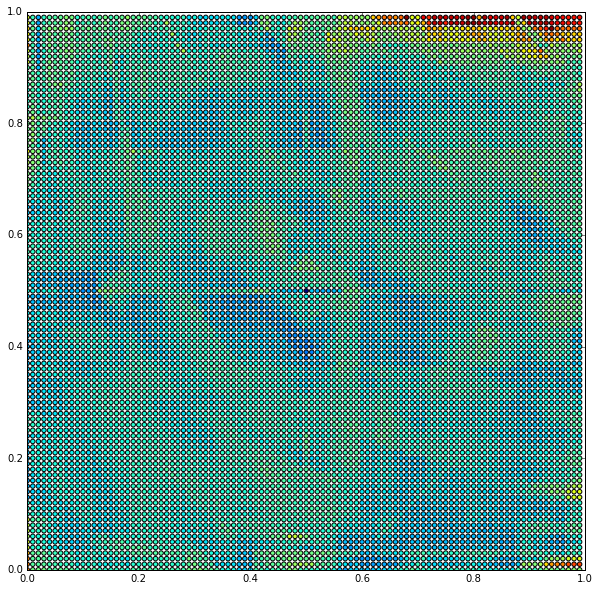

In [540]:
x, y = zip(*X_data[:, [0, -1]])
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=sigmas)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

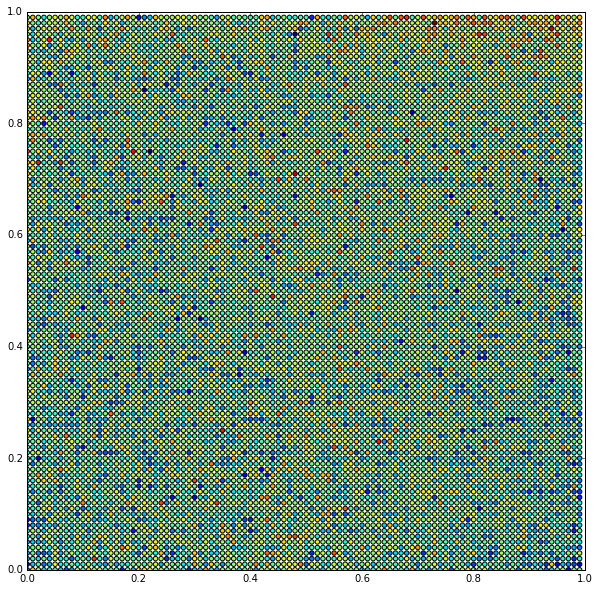

In [541]:
x, y = zip(*X_data[:, [0, -1]])
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=errors)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

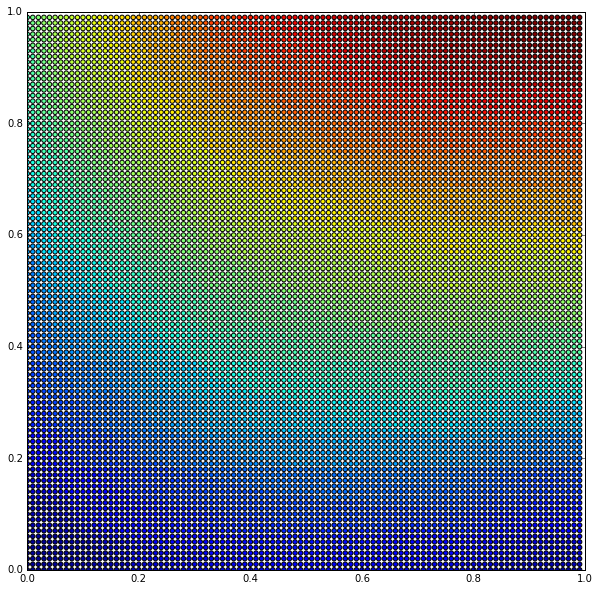

In [542]:
x, y = zip(*X_data[:, [0, -1]])
plt.figure(figsize=(10, 10))
plt.scatter(x, y, c=preds)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [537]:
print np.sum(np.abs(errors) <= 1.96 * sigmas) * 1. / len(errors)
print np.sum(np.abs(errors) <= 3. * sigmas) * 1. / len(errors)
print np.sum(np.abs(errors) <= 1. * sigmas) * 1. / len(errors)

0.969
0.9993
0.6946
